In [1]:
import pandas as pd

In [2]:
import json
with open('types.json', 'r') as f:
    data_types = json.load(f)

In [3]:
df = pd.read_feather('featherdata.feather')

In [4]:
df = df.astype(data_types)

### Clean Missing Values

In [5]:
from missing_values import some_nans, nas_sorted

def impute_means(df):
    nan_cols = some_nans(df)
    col_means = df[nan_cols].mean()
    imputed_df = df.fillna(col_means)
    return imputed_df

# find columns with nas, impute means

In [6]:
imputed_df = impute_means(df)

In [7]:
cleaned_df = imputed_df.drop(columns = ['host_acceptance_rate', 'jurisdiction_names'])

In [8]:
y = cleaned_df.price

In [9]:
X = cleaned_df.drop(columns=['price'])

In [10]:
some_nans(imputed_df)

Index([], dtype='object')

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [12]:
cleaned_df.isnull().values.any()

False

### Scale Data

In [13]:
from sklearn import preprocessing

In [14]:
scaled_features = preprocessing.scale(X)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.33, random_state=42)

In [24]:
estimator = LinearRegression()
estimator.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
coefs = estimator.coef_

In [26]:
cols = X.columns

In [28]:
import numpy as np
coefs_cols = np.stack((coefs, cols)).T

In [29]:
coefs_cols.sort(axis = 0)

In [32]:
# coefs_cols[40:]

In [33]:
import sklearn
p_vals = sklearn.feature_selection.f_regression(X_train, y_train, center=True)[-1]

In [34]:
p_val_cols = np.stack((p_vals, cols)).T

In [36]:
# p_val_cols

In [168]:
threshold_ps = p_val_cols[p_val_cols[:, 0] < .05]

In [169]:
threshold_ps.sort(axis = 0)

In [172]:
threshold_cols = threshold_ps[:, -1]

In [175]:
top_hundred_X =  X[threshold_cols]

In [176]:
scaled_top_hundred_X = preprocessing.scale(top_hundred_X)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [177]:
X_train_top, X_test_top, y_train, y_test = train_test_split(scaled_top_hundred_X, y, test_size=0.33, random_state=42)

In [178]:

# scaled_features = preprocessing.scale(X)
estimator = LinearRegression()
# estimator.fit(X_train, y_train)
estimator.fit(X_train_top, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [179]:
estimator.score(X_train_top, y_train)

0.16963907886754037

## Using RFE

In [181]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.33, random_state=42)

from sklearn.feature_selection import RFE
selectors = []
for idx in list(range(2, 300, 10))[::-1]:
    estimator = LinearRegression(n_jobs=-1)
    rfe = RFE(estimator, idx, step=1)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    
    estimator.fit(X_train_rfe,y_train)
    score = estimator.score(X_test_rfe,y_test)
    selectors.append((estimator, score, idx))

In [41]:

wrapped_selectors = np.array(selectors)
scores = wrapped_selectors[:, 1]
n_features = wrapped_selectors[:, -1]
n_features

array([292, 282, 272, 262, 252, 242, 232, 222, 212, 202, 192, 182, 172,
       162, 152, 142, 132, 122, 112, 102, 92, 82, 72, 62, 52, 42, 32, 22,
       12, 2], dtype=object)

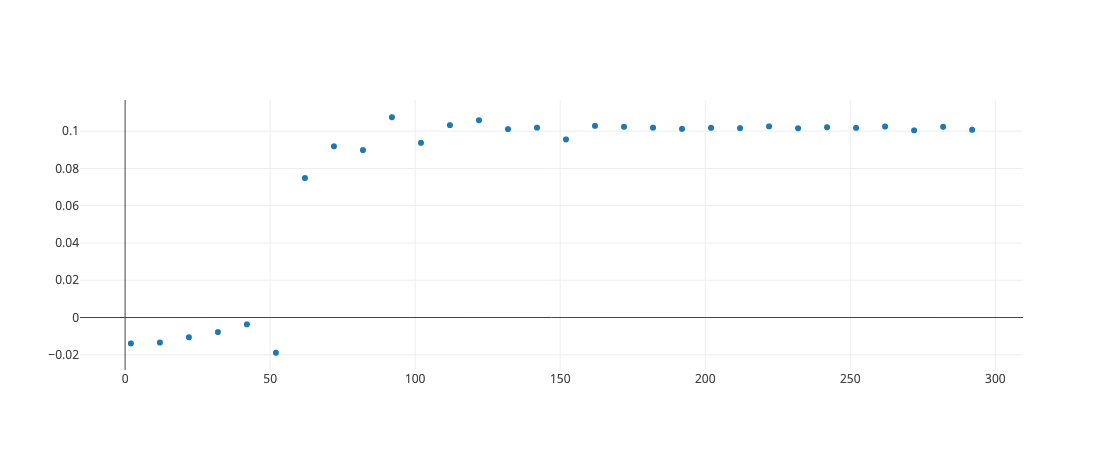

In [42]:
from graph import trace_values, plot
scores_trace = trace_values(n_features, scores)
plot([scores_trace])

### Weak Scores, Explore Outliers

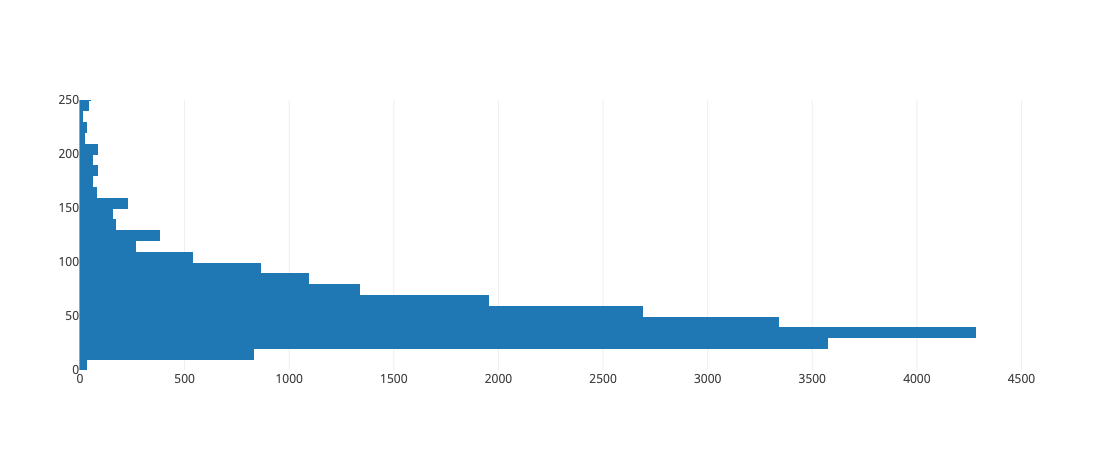

In [56]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np 

data = [go.Histogram(y=y)]
plot(data, layout = {'yaxis': {'range': [0, 250]}})

In [58]:
y.sort_values(ascending=False).head(10)

6655     9000.0
21389    8600.0
15665    8000.0
19372    6000.0
19415    6000.0
19657    6000.0
19658    6000.0
19659    6000.0
19660    6000.0
19661    6000.0
Name: price, dtype: float64

In [66]:
(y > 1000).sum()

37

In [72]:
step = 100
bin_range = np.arange(0, 500+step, step)
out, bins  = pd.cut(y, bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False)

[0, 100)      20016
[100, 200)     2040
[200, 300)      306
[300, 400)       73
[400, 500)       31
Name: price, dtype: int64

### Solution One: Clip the outliers

In [73]:
from sklearn.feature_selection import RFECV

In [74]:
model = LinearRegression(n_jobs = -1)
rfecv = RFECV(model, cv = 5)

In [77]:
X_train_rfecv = rfecv.fit(X_train,y_train)

In [81]:
y_values = X_train_rfecv.grid_scores_

In [82]:
x_values = list(range(0, 303))

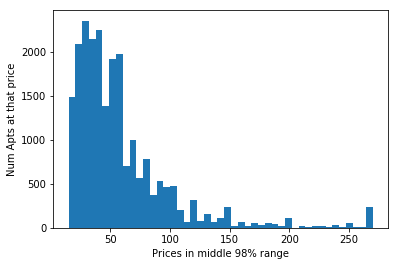

In [90]:
import matplotlib.pyplot as plt
lower, upper = np.percentile(y, [1,99]) # find middle 98% of prices
clipped = np.clip(y, upper, lower)
fig,ax = plt.subplots()
ax.set_xlabel('Prices in middle 98% range')
ax.set_ylabel('Num Apts at that price')
ax.hist(clipped, bins=45)
plt.show()

In [108]:
lower, upper

(15.0, 270.0)

In [96]:
cleaned_df.shape

(22552, 304)

In [101]:
clipped_df = cleaned_df[(lower < cleaned_df.price) & (cleaned_df.price < 270.0)]

In [104]:
y = clipped_df.price

In [105]:
X = clipped_df.drop(columns=['price'])

In [109]:
model = LinearRegression(n_jobs = -1)
rfecv = RFECV(model, cv = 5)

rfecv.fit(X,y)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [111]:
y_values = rfecv.grid_scores_
x_values = list(range(0, 303))

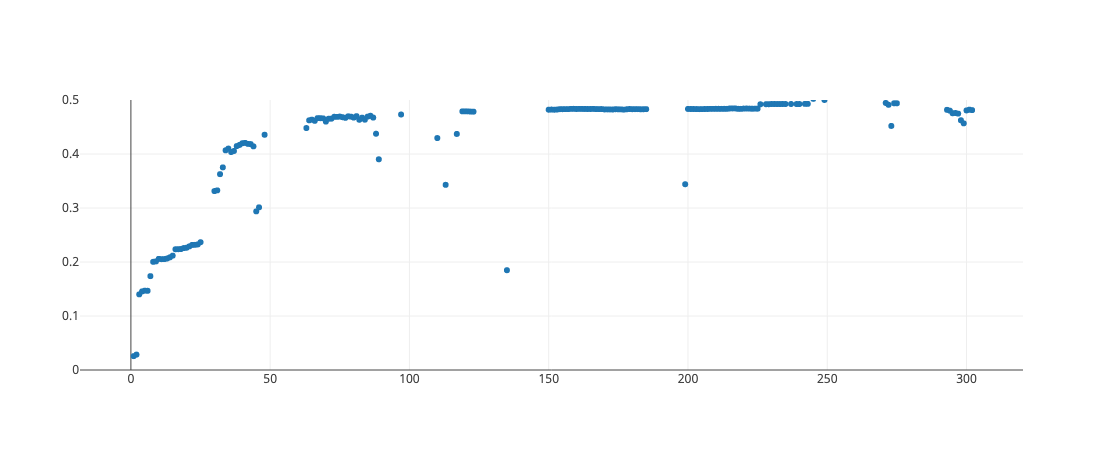

In [113]:
trace = trace_values(x_values, y_values)
plot([trace], {'yaxis': {'range': [0, .5]}})

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [125]:
from sklearn.feature_selection import RFE

In [126]:
rfe = RFE(model, n_features_to_select= 40)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
  n_features_to_select=40, step=1, verbose=0)

In [132]:
selected_columns = X_train.columns[rfe.support_]

In [134]:
model.fit(X_train[selected_columns], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [135]:
model.score(X_test[selected_columns], y_test)

0.3756859841009884

Not bad!

## Solution Two: Take the log

In [148]:
y_clipped_logged = np.log(clipped_df.price)
X = clipped_df.drop(columns=['price'])

In [149]:
model = LinearRegression(n_jobs = -1)
rfecv_log = RFECV(model, cv = 5)

rfecv_log.fit(X,y_clipped_logged)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [150]:
y_values_log_scores = rfecv_log.grid_scores_
x_values = list(range(0, 303))

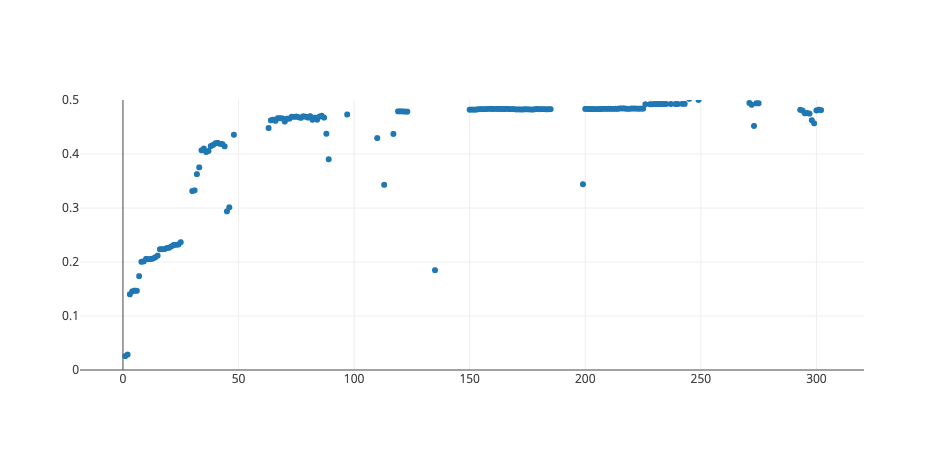

In [153]:
from graph import plot, trace_values

trace_logged_scores = trace_values(x_values, y_values_log_scores)
plot([trace], {'yaxis': {'range': [0, .5]}})

This didn't really help.

### Rank the features

### Recombine Features that appear Linear

In [320]:
features_limited_df = X[top_limited_cols]

In [331]:
from_dataset_df = pd.read_csv('listings_summary.csv.zip')

In [333]:
host_since = from_dataset_df.host_since

In [334]:
last_review = from_dataset_df.last_review

In [335]:
from date_lib import add_datepart

In [337]:
add_datepart(from_dataset_df, 'host_since')

In [338]:
add_datepart(from_dataset_df, 'last_review')

In [340]:
last_review_month = from_dataset_df.last_reviewMonth

In [341]:
host_sinceMonth = from_dataset_df.host_sinceMonth

In [421]:
last_reviewMonthcols = features_limited_df.loc[:, features_limited_df.columns.map(lambda x: x.startswith('last_reviewMonth'))].columns

In [422]:
len(last_reviewMonthcols)

11

In [423]:
hostSincecols = X.loc[:, X.columns.map(lambda x: x.startswith('host_sinceMonth'))]

In [424]:
cols_to_remove = list(hostSincecols) +  list(last_reviewMonthcols)

In [425]:
X_with_removed = X.drop(columns=cols_to_remove)

In [426]:
len(X_with_removed.columns)

281

In [427]:
X_with_removed['host_sinceMonth'] = host_sinceMonth

In [428]:
X_with_removed['last_reviewMonth'] = last_review_month

In [429]:
imputed_with_removed = impute_means(X_with_removed)

In [430]:
imputed_with_removed['price'] = cleaned_df.price

In [431]:
imputed_with_removed.to_feather('imputed_with_removed')

In [432]:
scaled_features_with_removed = preprocessing.scale(imputed_with_removed)
X_train, X_test, y_train, y_test = train_test_split(scaled_features_with_removed, y, test_size=0.33, random_state=42)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [433]:
#score 112
estimator = LinearRegression(n_jobs=-1)
rfe = RFE(estimator, 112, step=1)
X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.transform(X_test)

estimator.fit(X_train_rfe,y_train)
score = estimator.score(X_test_rfe,y_test)

def feature_importances(df, estimator):
    df_cols = df.columns[rfe.support_].to_numpy()
    coefs = estimator.coef_
    abs_coefs = abs(coefs)
    paired = np.hstack((df_cols.reshape(-1, 1), coefs.reshape(-1, 1), abs_coefs.reshape(-1, 1)))
    ordered_cols = paired[paired[:, -1].argsort()][::-1]
    return ordered_cols

In [434]:
def feature_importances(df, estimator):
    df_cols = df.columns[rfe.support_].to_numpy()
    coefs = estimator.coef_
    abs_coefs = abs(coefs)
    paired = np.hstack((df_cols.reshape(-1, 1), coefs.reshape(-1, 1), abs_coefs.reshape(-1, 1)))
    ordered_cols = paired[paired[:, -1].argsort()][::-1]
    return ordered_cols

In [435]:
importances = feature_importances(imputed_with_removed,estimator)

In [436]:
importances

array([['price', 220.2613265910614, 220.2613265910614],
       ['host_identity_verified_is_na', -13.27420077739558,
        13.27420077739558],
       ['host_has_profile_pic_is_na', -13.144912210070528,
        13.144912210070528],
       ['host_thumbnail_url_is_na', -10.49713016843962,
        10.49713016843962],
       ['host_listings_count_is_na', 10.42586174177467,
        10.42586174177467],
       ['host_name_is_na', 8.704628490767004, 8.704628490767004],
       ['host_total_listings_count_is_na', 7.919681003546115,
        7.919681003546115],
       ['host_picture_url_is_na', 7.430829168309159, 7.430829168309159],
       ['host_is_superhost_is_na', 5.976394250805642, 5.976394250805642],
       ['host_since_is_na', -3.5411514994905575, 3.5411514994905575],
       ['last_scrapedDay', -1.5122195303008361, 1.5122195303008361],
       ['reviews_per_month_is_na', -1.340751161136195, 1.340751161136195],
       ['first_review_is_na', 1.3407511603155513, 1.3407511603155513],
       ['nei

In [403]:
np.where(importances[:, 0] == 'last_reviewDayofyear')

(array([43]),)

In [411]:
import pandas as pd 

pd.DataFrame(importances[:43]).to_csv("importances.csv")

In [414]:
# pd.read_csv('importances.csv').to_numpy()[:, 1:]

### From here can dedicate feature engineering

### Resources

* Feature selection in theory
    * Want those that are correlated, or pearson correlated with the outputs
        * Could compare both techniques

In [ ]:
https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2